In [1]:
import matplotlib.pyplot as plt
import mdp.offroad_grid as offroad_grid
import numpy as np
from network.hybrid_dilated import HybridDilated
from torch.autograd import Variable
import torch
from os.path import join
import scipy.io as sio
from loader.util import leastsq_circle, calc_sign
import seaborn as sns
import viz

In [2]:
# initialize parameters
grid_size = 80 # local grid environment size
discount = 0.9
model = offroad_grid.OffroadGrid(grid_size, discount)
n_states = model.n_states
n_actions = model.n_actions

net = HybridDilated(feat_out_size=25, regression_hidden_size=64)
net.init_weights()
net.load_state_dict(torch.load(join('example_data', 'example_weights.pth'))['net_state'])
net.eval()

/home/yf/git_repo/vehicle-motion-forecasting/network/hybrid_dilated.py:59: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(mod.weight, a=0)


HybridDilated(
  (feat_block): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): ReflectionPad2d((2, 2, 2, 2))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (5): ReLU(inplace)
    (6): ReflectionPad2d((5, 5, 5, 5))
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(5, 5))
    (8): ReLU(inplace)
    (9): ReflectionPad2d((1, 1, 1, 1))
    (10): Conv2d(64, 25, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace)
  )
  (regression_block): Sequential(
    (0): Conv2d(30, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace)
    (6): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [13]:
def load(grid_size, fname):
    """ load sample demo input data"""
    mean_std = sio.loadmat(join('example_data', 'data_mean_std.mat'))
    data_mat = sio.loadmat(join('example_data', fname))
    feat = data_mat['feat']
    # pre-process environment input
    feat[0] = (feat[0] - np.mean(feat[0])) / np.std(feat[0]) # normalize max-height feature locally (w.r.t. robot frame)
    feat[1] = (feat[1] - mean_std['variance_mean']) / mean_std['variance_std']
    feat[2] = (feat[2] - mean_std['red_mean']) / mean_std['red_std']
    feat[3] = (feat[3] - mean_std['green_mean']) / mean_std['green_std']
    feat[4] = (feat[4] - mean_std['blue_mean']) / mean_std['blue_std']
    
    # pre-process kinematic input
    past_traj, future_traj = data_mat['past_traj'], data_mat['future_traj']
    x, y = past_traj[:, 0], past_traj[:, 1]
    xc, yc, r, _ = leastsq_circle(x, y)
    curve_sign = calc_sign(x[0], y[0], x[-1], y[-1], xc, yc)
    kappa = 1.0 / r * curve_sign * 10.0 # 10.0 is empirically selected by observing the histogram
    feat = np.vstack((feat, np.full((1, grid_size, grid_size), kappa, dtype=np.float)))
    
    normalization = 0.5 * grid_size # 0.5*grid_size is used for normalize vx, vy, coordinate layers
    vx = (past_traj[-1, 0] - past_traj[0, 0]) / normalization
    vy = (past_traj[-1, 1] - past_traj[0 ,1]) / normalization
    feat = np.vstack((feat, np.full((1, grid_size, grid_size), vx, dtype=np.float)))
    feat = np.vstack((feat, np.full((1, grid_size, grid_size), vy, dtype=np.float)))

    # coordinate layer
    center_idx = grid_size / 2
    delta_x_layer = np.zeros((1, grid_size, grid_size), dtype=np.float)
    delta_y_layer = delta_x_layer.copy()
    for x in range(grid_size):
        for y in range(grid_size):
            delta_x_layer[0, x, y] = x - center_idx
            delta_y_layer[0, x, y] = y - center_idx
    feat = np.vstack((feat, delta_x_layer / normalization))
    feat = np.vstack((feat, delta_y_layer / normalization))
    
    return feat, past_traj, future_traj

In [14]:
feat, past_traj, future_traj = load(grid_size, 'example_input_narrow_trail.mat')
feat_var = Variable(torch.from_numpy(np.expand_dims(feat, axis=0)).float())
r_var = net(feat_var) # forward reward inference

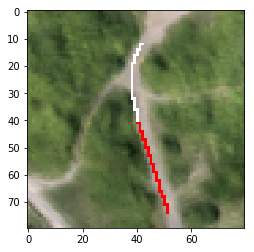

In [15]:
# visualize input: traj overlayed with top-down RGB
rgb = viz.feat2rgb(feat)
rgb_with_traj = viz.overlay(rgb, future_traj, past_traj)
plt.imshow(rgb_with_traj)
plt.show()

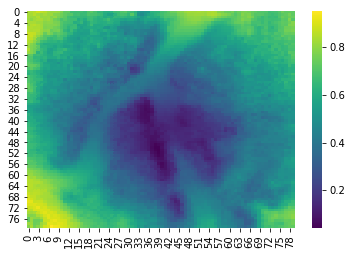

In [16]:
r = r_var[0].data.numpy().squeeze()
sns.heatmap(r, cmap='viridis')
plt.show()

find_optimal_value. iteration 38, last update 0.00961954428426015


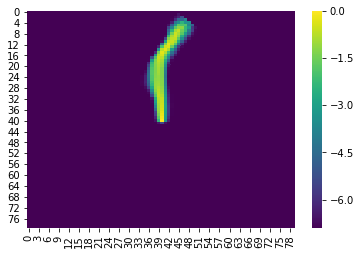

In [17]:
r_vector = r.reshape(n_states) # convert 2D reward matrix to a 1D vector
value_vector = model.find_optimal_value(r_vector, 0.01)
policy = model.find_stochastic_policy(value_vector, r_vector)
past_traj_len = past_traj.shape[0]
svf_vector = model.find_svf_demo(policy, past_traj_len)
svf = np.log(svf_vector.reshape(grid_size, grid_size) + 1e-3)
sns.heatmap(svf, cmap='viridis')
plt.show()